# Data analysis and preprocessing
En este notebook ejecutamos el preprocessing y podemos ver la información del dataset y como esta cambia durante el preproceso de los datos.

In [49]:
import gc
import re
import data_preprocessing as dpp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from auxiliar_functions import extract_info
# global
data_path = '../Data/'

In [50]:
# load and merge data
# important: del and gc calls for performance and memory issues.
df_train = pd.read_csv(data_path + 'train.csv', dtype={'target': np.uint8})
df_members = pd.read_csv(data_path + 'members.csv')
df_merged = df_train.merge(df_members, on='msno', how='left')
del df_train, df_members
gc.collect()
df_songs = pd.read_csv(data_path + 'songs.csv')
df_merged = df_merged.merge(df_songs, on='song_id', how='left')
del df_songs
gc.collect()
df_song_extra = pd.read_csv(data_path + 'song_extra_info.csv')
df_merged = df_merged.merge(df_song_extra, on='song_id', how='left')
del df_song_extra
gc.collect()

21

In [51]:
df_merged.head() # first rows of the data frame as example

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003


In [52]:
len(df_merged.columns) # number of columns

20

In [53]:
len(df_merged) # number of rows

7377418

In [54]:
merged_info = extract_info(df_merged) # number of nulls, percentage of nulls, data types
merged_info

,null_count,null_percentage,dtypes
msno,0,0.000000,object
song_id,0,0.000000,object
source_system_tab,24849,0.336825,object
source_screen_name,414804,5.622618,object
source_type,21539,0.291959,object
target,0,0.000000,uint8
city,0,0.000000,int64
bd,0,0.000000,int64
gender,2961479,40.142486,object
registered_via,0,0.000000,int64


In [55]:
features_dict = {}
categoricals = ['msno', 'song_id', 'source_system_tab', 'source_screen_name',\
                'source_type', 'target', 'city', 'gender', 'registered_via',\
                'artist_name', 'language', 'name', 'isrc']
categoricals_multi = ['genre_ids', 'composer', 'lyricist']
for feature in categoricals:
    features_dict[feature] = len(dpp.make_set_categories(df_merged[feature], split=False))
    gc.collect()
for feature in categoricals_multi:
    features_dict[feature] = len(dpp.make_set_categories(df_merged[feature]))
    gc.collect()
features_dict

{'artist_name': 40582,
 'city': 21,
 'composer': 81566,
 'gender': 2,
 'genre_ids': 166,
 'isrc': 269760,
 'language': 10,
 'lyricist': 38473,
 'msno': 30755,
 'name': 234144,
 'registered_via': 5,
 'song_id': 359966,
 'source_screen_name': 20,
 'source_system_tab': 8,
 'source_type': 12,
 'target': 2}

## Treatment of Lost Values

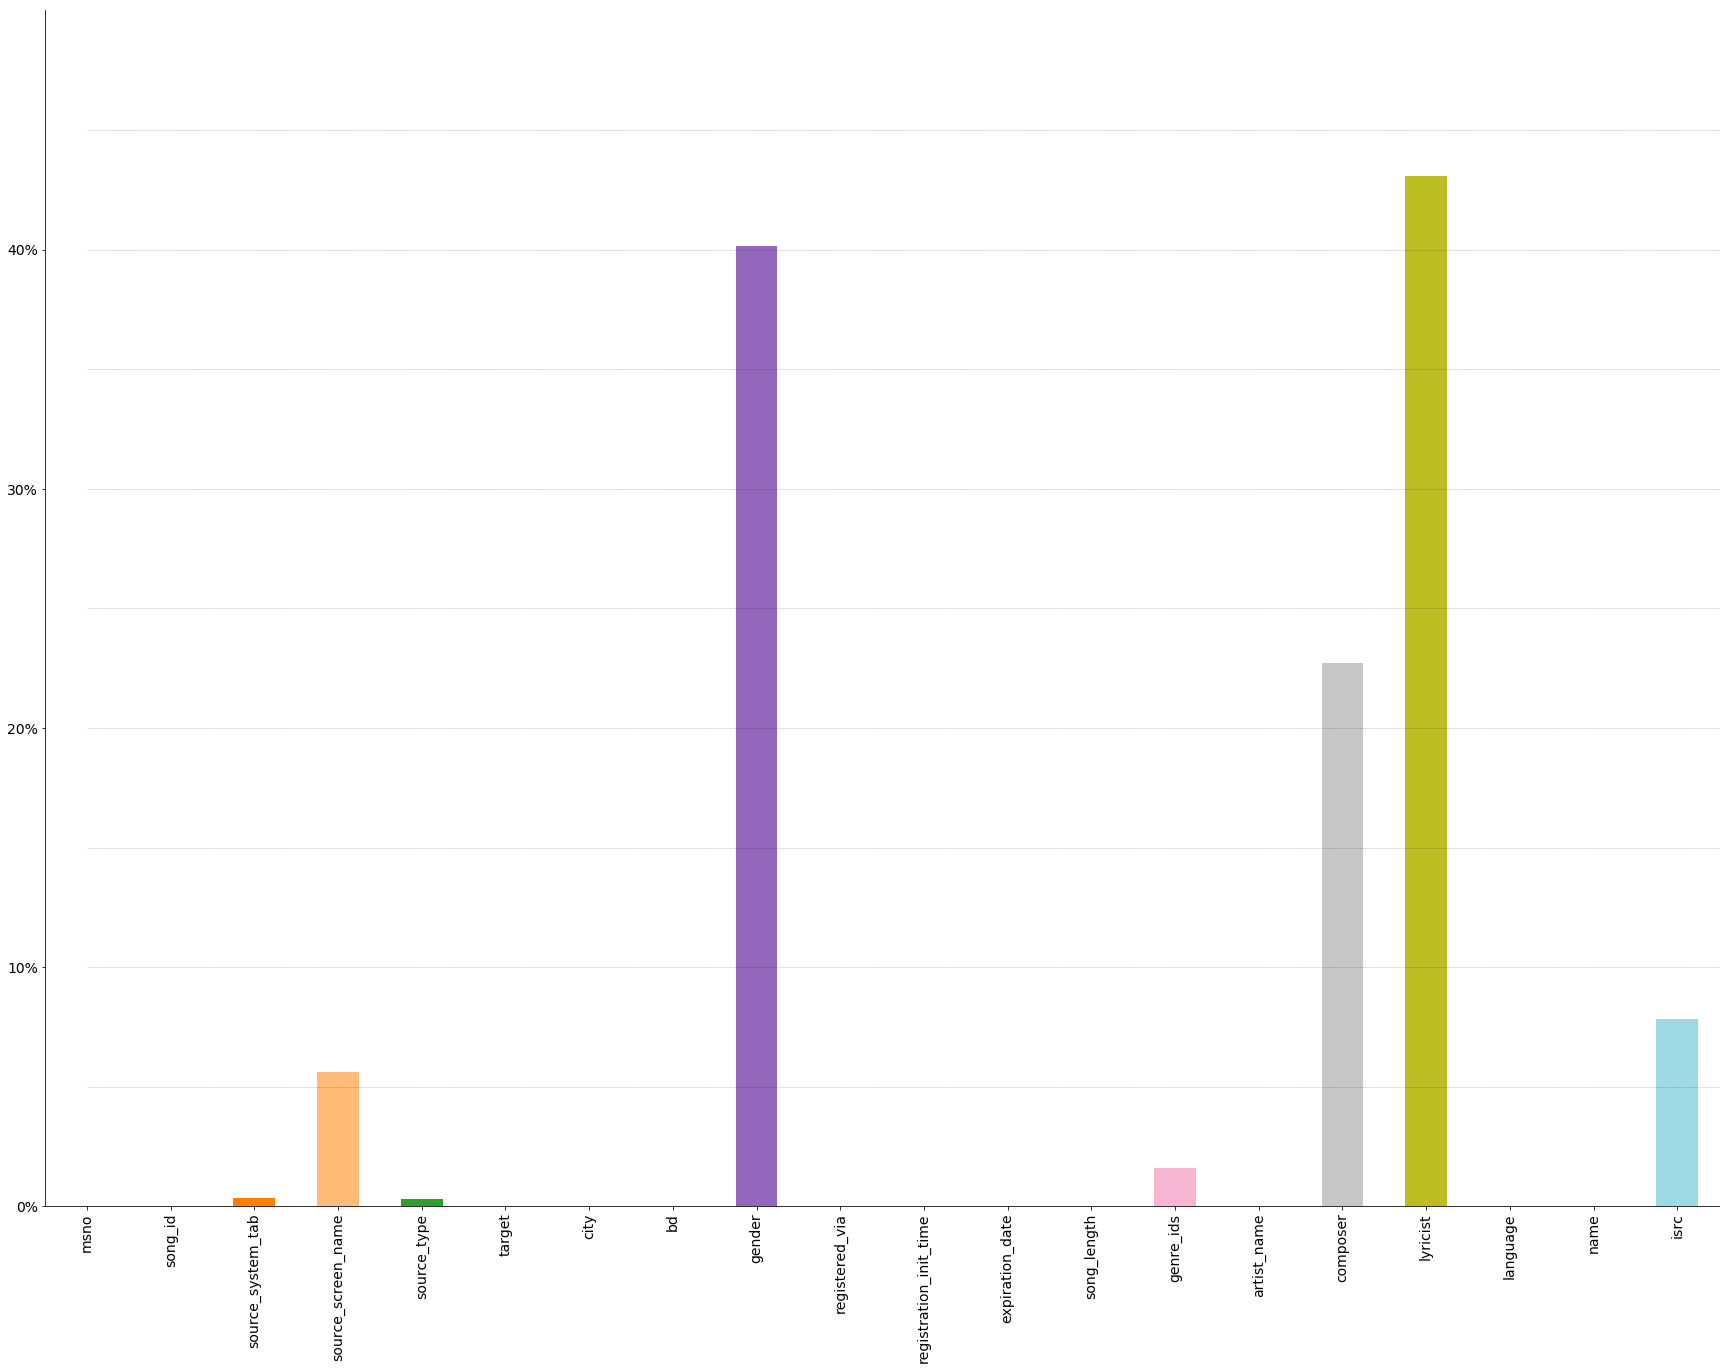

In [56]:
dpp.plot_lost_values_percent(merged_info['null_percentage'])

#### Remove gender, composer and lyricist features

In [57]:
rm_columns = ['gender', 'composer', 'lyricist']
df_merged = df_merged.drop(columns=rm_columns)
df_merged.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,7,20120102,20171005,206471.0,359,Bastille,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,9,20110525,20170911,284584.0,1259,Various Artists,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,9,20110525,20170911,225396.0,1259,Nas,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,9,20110525,20170911,255512.0,1019,Soundway,-1.0,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,7,20120102,20171005,187802.0,1011,Brett Young,52.0,Sleep Without You,QM3E21606003


#### Drop NA

In [58]:
df_merged = df_merged.dropna()

#### Dataset after treatment of lost values

In [59]:
len(df_merged.columns) # number of columns

17

In [60]:
len(df_merged) # number of rows

6317407

In [61]:
merged_info = extract_info(df_merged) # number of nulls, percentage of nulls, data types
merged_info

,null_count,null_percentage,dtypes
msno,0,0.0,object
song_id,0,0.0,object
source_system_tab,0,0.0,object
source_screen_name,0,0.0,object
source_type,0,0.0,object
target,0,0.0,uint8
city,0,0.0,int64
bd,0,0.0,int64
registered_via,0,0.0,int64
registration_init_time,0,0.0,int64


## Outliers treatment: bd feature

In [62]:
df_merged['bd'] = df_merged['bd'].apply(dpp.bd_nanify_outlier)

In [63]:
extract_info(df_merged).loc['bd']

null_count         2507053
null_percentage    39.6848
dtypes             float64
Name: bd, dtype: object

#### Remove bd feature

In [64]:
df_merged = df_merged.drop(columns=['bd'])
df_merged.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,7,20120102,20171005,206471.0,359,Bastille,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,9,20110525,20170911,284584.0,1259,Various Artists,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,9,20110525,20170911,225396.0,1259,Nas,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,9,20110525,20170911,255512.0,1019,Soundway,-1.0,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,7,20120102,20171005,187802.0,1011,Brett Young,52.0,Sleep Without You,QM3E21606003


In [65]:
list(df_merged.columns)

['msno',
 'song_id',
 'source_system_tab',
 'source_screen_name',
 'source_type',
 'target',
 'city',
 'registered_via',
 'registration_init_time',
 'expiration_date',
 'song_length',
 'genre_ids',
 'artist_name',
 'language',
 'name',
 'isrc']

### Feature extraction: get song_year from ISRC

In [66]:
df_merged['song_year'] = df_merged['isrc']
df_merged['song_year'] = df_merged['song_year'].apply(dpp.process_isrc)

In [67]:
df_merged[['song_year']].head()

,song_year
0,2016
1,1999
2,2006
3,2010
4,2016


In [68]:
merged_info = extract_info(df_merged) # number of nulls, percentage of nulls, data types
merged_info

,null_count,null_percentage,dtypes
msno,0,0.0,object
song_id,0,0.0,object
source_system_tab,0,0.0,object
source_screen_name,0,0.0,object
source_type,0,0.0,object
target,0,0.0,uint8
city,0,0.0,int64
registered_via,0,0.0,int64
registration_init_time,0,0.0,int64
expiration_date,0,0.0,int64


## Feature Selection: remove some features

In [69]:
rm_columns = ['msno', 'song_id', 'registered_via', 'registration_init_time',\
              'expiration_date', 'artist_name', 'name', 'isrc']
df_merged = df_merged.drop(columns=rm_columns)
df_merged.head()

,source_system_tab,source_screen_name,source_type,target,city,song_length,genre_ids,language,song_year
0,explore,Explore,online-playlist,1,1,206471.0,359,52.0,2016
1,my library,Local playlist more,local-playlist,1,13,284584.0,1259,52.0,1999
2,my library,Local playlist more,local-playlist,1,13,225396.0,1259,52.0,2006
3,my library,Local playlist more,local-playlist,1,13,255512.0,1019,-1.0,2010
4,explore,Explore,online-playlist,1,1,187802.0,1011,52.0,2016


In [70]:
len(df_merged.columns) # number of columns

9

In [71]:
len(df_merged) # number of rows

6317407

In [72]:
merged_info = extract_info(df_merged) # number of nulls, percentage of nulls, data types
merged_info

,null_count,null_percentage,dtypes
source_system_tab,0,0.0,object
source_screen_name,0,0.0,object
source_type,0,0.0,object
target,0,0.0,uint8
city,0,0.0,int64
song_length,0,0.0,float64
genre_ids,0,0.0,object
language,0,0.0,float64
song_year,0,0.0,int64


### Categorical features: set unique genre_ids

In [74]:
len(dpp.make_set_categories(df_merged['genre_ids']))

163

In [75]:
genres_dict = dpp.count_genres_freq(df_merged)
genres_dict

{'1000': 6,
 '1007': 52,
 '1011': 38141,
 '1019': 38,
 '102': 38,
 '1026': 19,
 '1033': 21,
 '1040': 198,
 '1047': 212,
 '1054': 77,
 '1068': 24,
 '1082': 507,
 '109': 30682,
 '1096': 69,
 '1103': 49,
 '1110': 29,
 '1117': 10,
 '1124': 2,
 '1131': 2,
 '1138': 630,
 '1145': 196,
 '1152': 11032,
 '1155': 281,
 '1162': 8,
 '1169': 20,
 '118': 1001,
 '1180': 5146,
 '1187': 4,
 '1194': 5,
 '1201': 6,
 '1208': 232,
 '125': 26489,
 '1259': 206960,
 '1266': 8,
 '1273': 130,
 '1280': 59,
 '1287': 4869,
 '139': 96740,
 '152': 2,
 '1568': 109,
 '1572': 5124,
 '1579': 1,
 '1598': 80,
 '1605': 895,
 '1609': 340690,
 '1616': 52832,
 '1630': 60,
 '1633': 311,
 '177': 54,
 '184': 58,
 '191': 68,
 '1944': 10,
 '1955': 2840,
 '1965': 13,
 '1969': 405,
 '1977': 77,
 '198': 25,
 '1981': 67,
 '1988': 48,
 '1995': 3628,
 '2008': 2,
 '2015': 4,
 '2022': 150358,
 '2029': 83,
 '2032': 516,
 '205': 23,
 '2052': 33,
 '2058': 1390,
 '2065': 16,
 '2072': 938,
 '2079': 933,
 '2086': 1093,
 '2093': 1026,
 '2100': 73

In [76]:
df_merged['genre_ids'] = df_merged['genre_ids'].apply(lambda x: dpp.get_max_genre(x, genres_dict))
df_merged.head()

,source_system_tab,source_screen_name,source_type,target,city,song_length,genre_ids,language,song_year
0,explore,Explore,online-playlist,1,1,206471.0,359,52.0,2016
1,my library,Local playlist more,local-playlist,1,13,284584.0,1259,52.0,1999
2,my library,Local playlist more,local-playlist,1,13,225396.0,1259,52.0,2006
3,my library,Local playlist more,local-playlist,1,13,255512.0,1019,-1.0,2010
4,explore,Explore,online-playlist,1,1,187802.0,1011,52.0,2016


In [77]:
merged_info = extract_info(df_merged)
merged_info

,null_count,null_percentage,dtypes
source_system_tab,0,0.0,object
source_screen_name,0,0.0,object
source_type,0,0.0,object
target,0,0.0,uint8
city,0,0.0,int64
song_length,0,0.0,float64
genre_ids,0,0.0,object
language,0,0.0,float64
song_year,0,0.0,int64


In [78]:
len(dpp.make_set_categories(df_merged['genre_ids']))

148

## Write csv

In [17]:
df_merged.to_csv(data_path + 'df_clean.csv')